In [189]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# system related and data input controls
import os
import datetime

# data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # number format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import yfinance as yf

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
tf.get_logger().warning('test')
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, SimpleRNN
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# evaluation metrics
from sklearn import metrics

# for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm


In [190]:
# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

In [191]:
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        ##### 시각화
        # 잔차의 정규본포성 확인
        # sns.displot(Residual, norm_hist='True', fit=stats.norm)
        sns.displot(Residual, kind='hist')
        plt.show()

        # 잔차의 등분산성 확인
        temp = pd.concat([Y_Pred, Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Pred', y='Error', data=temp)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation], join='outer', axis=1)
    
    return Error_Analysis

In [192]:
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

In [193]:
# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

In [194]:
df_tesla = pd.DataFrame()

In [195]:
# get tesla stock data
tesla = yf.Ticker("TSLA")
tesla_df = tesla.history(period="max")
tesla_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-06-12 00:00:00-04:00,247.94,250.97,244.59,249.83,150337900,0.00,0.00
2023-06-13 00:00:00-04:00,253.51,259.68,251.34,258.71,162384300,0.00,0.00
2023-06-14 00:00:00-04:00,260.17,261.57,250.50,256.79,170575500,0.00,0.00
2023-06-15 00:00:00-04:00,248.40,258.95,247.29,255.90,160171200,0.00,0.00
2023-06-16 00:00:00-04:00,258.92,263.60,257.21,260.54,167563700,0.00,0.00


In [196]:
tesla_df.index = pd.to_datetime(tesla_df.index).strftime('%Y-%m-%d')
df_tesla['price'] = tesla_df['Close']
df_tesla

,price
Date,
2010-06-29,1.59
2010-06-30,1.59
2010-07-01,1.46
2010-07-02,1.28
2010-07-06,1.07
...,...
2023-06-12,249.83
2023-06-13,258.71
2023-06-14,256.79


## Exchange rate (ESD-EUR)

In [197]:
# get exchange rate
eur_usd= yf.Ticker("EURUSD=X")
eur_usd_df = eur_usd.history(period="max")
eur_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-01 00:00:00+00:00,1.20,1.20,1.19,1.20,0,0.00,0.00
2003-12-02 00:00:00+00:00,1.20,1.21,1.19,1.21,0,0.00,0.00
2003-12-03 00:00:00+00:00,1.21,1.21,1.21,1.21,0,0.00,0.00
2003-12-04 00:00:00+00:00,1.21,1.21,1.20,1.21,0,0.00,0.00
2003-12-05 00:00:00+00:00,1.21,1.22,1.21,1.22,0,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-13 00:00:00+01:00,1.08,1.08,1.08,1.08,0,0.00,0.00
2023-06-14 00:00:00+01:00,1.08,1.09,1.08,1.08,0,0.00,0.00
2023-06-15 00:00:00+01:00,1.08,1.09,1.08,1.08,0,0.00,0.00


In [198]:
eur_usd_df.index = pd.to_datetime(eur_usd_df.index).strftime('%Y-%m-%d')
df_tesla['eur_usd'] = eur_usd_df['Close']
df_tesla

,price,eur_usd
Date,,
2010-06-29,1.59,1.22
2010-06-30,1.59,1.22
2010-07-01,1.46,1.25
2010-07-02,1.28,1.26
2010-07-06,1.07,1.26
...,...,...
2023-06-12,249.83,1.08
2023-06-13,258.71,1.08
2023-06-14,256.79,1.08


## Exchange rate (usd/cny)

In [199]:
cny_usd = yf.Ticker("CNYUSD=X")
cny_usd_df = cny_usd.history(period="max")
cny_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-25 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-06-26 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-02 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-09 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-11 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-13 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00
2023-06-14 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00
2023-06-15 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00


In [200]:
cny_usd_df.index = pd.to_datetime(cny_usd_df.index).strftime('%Y-%m-%d')
df_tesla['cny_usd'] = cny_usd_df['Close']
df_tesla

,price,eur_usd,cny_usd
Date,,,
2010-06-29,1.59,1.22,0.15
2010-06-30,1.59,1.22,0.15
2010-07-01,1.46,1.25,0.15
2010-07-02,1.28,1.26,0.15
2010-07-06,1.07,1.26,0.15
...,...,...,...
2023-06-12,249.83,1.08,0.14
2023-06-13,258.71,1.08,0.14
2023-06-14,256.79,1.08,0.14


In [201]:
def get_data(ticker_code, index_name, peroiod="max"):
    # get the data
    data = yf.Ticker(ticker_code)
    data = data.history(period=peroiod)
    data.insert(0, "code", ticker_code)
    data.insert(0, "index_name", index_name)

    ## change column name into small letters
    data = data.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Dividends": "dividends", "Stock Splits": "stock_splits"})
    data.index.name = "date"

    ## change data format
    data.index = pd.to_datetime(data.index, format='%d-%m-%Y')
    data.index = data.index.strftime('%Y-%m-%d')
    data["open"] = data["open"].astype(float)
    data["high"] = data["high"].astype(float)
    data["low"] = data["low"].astype(float)
    data["close"] = data["close"].astype(float)
    data["volume"] = data["volume"].astype(int)
    data["dividends"] = data["dividends"].astype(float)
    data["stock_splits"] = data["stock_splits"].astype(float)

    ## mange missing data
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(0)
    data = data.round(2)

    return data

## Dow jones

In [202]:
dowjones = yf.Ticker("^DJI")
dowjones_df = dowjones.history(period="max")
dowjones_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1992-01-02 00:00:00-05:00,"3,152.10","3,172.63","3,139.31","3,172.40",23550000,0.00,0.00
1992-01-03 00:00:00-05:00,"3,172.40","3,210.64","3,165.92","3,201.50",23620000,0.00,0.00
1992-01-06 00:00:00-05:00,"3,201.50","3,213.33","3,191.86","3,200.10",27280000,0.00,0.00
1992-01-07 00:00:00-05:00,"3,200.10","3,210.20","3,184.48","3,204.80",25510000,0.00,0.00
1992-01-08 00:00:00-05:00,"3,204.80","3,229.20","3,185.82","3,203.90",29040000,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-12 00:00:00-04:00,"33,906.80","34,077.84","33,878.46","34,066.33",308130000,0.00,0.00
2023-06-13 00:00:00-04:00,"34,111.08","34,310.28","34,107.98","34,212.12",308790000,0.00,0.00
2023-06-14 00:00:00-04:00,"34,044.70","34,151.42","33,783.55","33,979.33",354910000,0.00,0.00


In [203]:
dowjones_df.index = pd.to_datetime(dowjones_df.index).strftime('%Y-%m-%d')
df_tesla['dowjones'] = dowjones_df['Close']
df_tesla

,price,eur_usd,cny_usd,dowjones
Date,,,,
2010-06-29,1.59,1.22,0.15,"9,870.30"
2010-06-30,1.59,1.22,0.15,"9,774.02"
2010-07-01,1.46,1.25,0.15,"9,732.53"
2010-07-02,1.28,1.26,0.15,"9,686.48"
2010-07-06,1.07,1.26,0.15,"9,743.62"
...,...,...,...,...
2023-06-12,249.83,1.08,0.14,"34,066.33"
2023-06-13,258.71,1.08,0.14,"34,212.12"
2023-06-14,256.79,1.08,0.14,"33,979.33"


## Sector ETF

In [204]:
# us stock sector indexes code: XLK, XLV, XLY, XLP, XLE, XLF, XLI, XLB, XLRE, XLU

us_sector_indexes = ['XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLF', 'XLI', 'XLB', 'XLRE', 'XLU']

for index_code in us_sector_indexes:
    index_name = index_code
    index_df = get_data(index_code, index_name)
    df_tesla[index_name] = index_df['close']

df_tesla

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU
Date,,,,,,,,,,,,,,
2010-06-29,1.59,1.22,0.15,"9,870.30",17.17,22.87,24.93,18.23,32.68,8.97,21.51,21.61,NaN,18.18
2010-06-30,1.59,1.22,0.15,"9,774.02",16.90,22.68,24.62,18.10,32.43,8.86,21.37,21.40,NaN,18.06
2010-07-01,1.46,1.25,0.15,"9,732.53",16.84,22.49,24.82,18.14,32.31,8.78,21.31,21.28,NaN,17.98
2010-07-02,1.28,1.26,0.15,"9,686.48",16.81,22.55,24.55,18.07,32.23,8.68,21.04,21.15,NaN,18.00
2010-07-06,1.07,1.26,0.15,"9,743.62",16.98,22.66,24.55,18.17,32.55,8.73,21.08,21.18,NaN,18.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,249.83,1.08,0.14,"34,066.33",169.62,130.89,163.97,73.09,80.55,33.14,103.13,79.36,37.10,66.27
2023-06-13,258.71,1.08,0.14,"34,212.12",170.65,131.55,165.67,73.39,80.93,33.34,104.33,81.20,37.37,66.26
2023-06-14,256.79,1.08,0.14,"33,979.33",172.41,130.20,165.55,73.84,80.10,33.21,104.05,80.86,37.57,66.22


# treasury bond

In [205]:
# t_bond = yf.Ticker("^IRX")
# t_bond_df = dowjones.history(period="max")
# t_bond_df

In [206]:
t_bills_df = pd.read_csv('./data/^IRX.csv')
t_bills_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1960-01-04,4.52,4.52,4.52,4.52,4.52,0.00
1,1960-01-05,4.55,4.55,4.55,4.55,4.55,0.00
2,1960-01-06,4.68,4.68,4.68,4.68,4.68,0.00
3,1960-01-07,4.63,4.63,4.63,4.63,4.63,0.00
4,1960-01-08,4.59,4.59,4.59,4.59,4.59,0.00
...,...,...,...,...,...,...,...
19720,2023-06-12,5.10,5.11,5.08,5.09,5.09,0.00
19721,2023-06-13,5.13,5.13,5.04,5.10,5.10,0.00
19722,2023-06-14,5.09,5.11,5.00,5.08,5.08,0.00
19723,2023-06-15,5.07,5.08,5.05,5.05,5.05,0.00


In [207]:
t_bills_df.set_index(keys=['Date'], inplace=True, drop=True)

In [208]:
df_tesla['t_bills'] = t_bills_df['Close']

In [209]:
df_tesla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 2010-06-29 to 2023-06-16
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     3265 non-null   float64
 1   eur_usd   3260 non-null   float64
 2   cny_usd   3259 non-null   float64
 3   dowjones  3265 non-null   float64
 4   XLK       3265 non-null   float64
 5   XLV       3265 non-null   float64
 6   XLY       3265 non-null   float64
 7   XLP       3265 non-null   float64
 8   XLE       3265 non-null   float64
 9   XLF       3265 non-null   float64
 10  XLI       3265 non-null   float64
 11  XLB       3265 non-null   float64
 12  XLRE      1936 non-null   float64
 13  XLU       3265 non-null   float64
 14  t_bills   3262 non-null   float64
dtypes: float64(15)
memory usage: 408.1+ KB


In [210]:
df_tesla.dropna(inplace=True)
df_tesla

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU,t_bills
Date,,,,,,,,,,,,,,,
2015-10-08,15.11,1.12,0.16,"17,050.75",37.44,60.13,71.00,40.47,50.19,16.37,46.18,37.90,23.33,34.47,0.00
2015-10-09,14.71,1.13,0.16,"17,084.49",37.60,60.41,71.08,40.56,49.86,16.26,46.34,37.88,23.29,34.30,0.00
2015-10-12,14.37,1.14,0.16,"17,131.86",37.65,60.57,71.42,40.67,49.22,16.28,46.34,37.56,23.44,34.61,0.01
2015-10-13,14.62,1.14,0.16,"17,081.89",37.57,59.81,71.04,40.42,48.70,16.15,45.85,37.41,23.29,34.53,0.01
2015-10-14,14.46,1.14,0.16,"16,924.75",37.49,59.69,70.31,39.96,49.12,16.02,45.35,37.71,23.29,34.52,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,249.83,1.08,0.14,"34,066.33",169.62,130.89,163.97,73.09,80.55,33.14,103.13,79.36,37.10,66.27,5.09
2023-06-13,258.71,1.08,0.14,"34,212.12",170.65,131.55,165.67,73.39,80.93,33.34,104.33,81.20,37.37,66.26,5.10
2023-06-14,256.79,1.08,0.14,"33,979.33",172.41,130.20,165.55,73.84,80.10,33.21,104.05,80.86,37.57,66.22,5.08


In [211]:
# start_date
# df_tesla = df_tesla.loc[df_tesla.index >= '2020-01-01']
# df_tesla

# Data preprocessing

In [212]:
# # y data to return
df_tesla['return'] = df_tesla['price'].pct_change(periods=10)
df_tesla[['price', 'eur_usd', 'cny_usd', 'dowjones', 'XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLF', 'XLI', 'XLB', 'XLRE', 'XLU', 't_bills', 'return']] = df_tesla[['price', 'eur_usd', 'cny_usd', 'dowjones', 'XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLF', 'XLI', 'XLB', 'XLRE', 'XLU', 't_bills', 'return']].rolling(10).mean()
df_tesla.dropna(inplace=True)
df_tesla

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU,t_bills,return
Date,,,,,,,,,,,,,,,,
2015-11-04,14.21,1.10,0.16,"17,715.37",39.69,62.67,73.65,41.29,49.45,16.95,47.33,38.71,24.05,34.60,0.03,-0.03
2015-11-05,14.35,1.10,0.16,"17,752.80",39.83,63.04,73.85,41.20,49.57,16.99,47.36,38.76,24.02,34.47,0.04,-0.01
2015-11-06,14.50,1.10,0.16,"17,779.16",39.88,63.25,74.02,41.08,49.68,17.03,47.38,38.78,23.93,34.29,0.05,0.00
2015-11-09,14.57,1.10,0.16,"17,789.90",39.90,63.39,74.03,40.93,49.87,17.06,47.37,38.82,23.83,34.13,0.05,0.01
2015-11-10,14.61,1.09,0.16,"17,807.58",39.92,63.46,74.14,40.79,50.12,17.11,47.41,38.84,23.74,34.01,0.06,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,221.92,1.07,0.14,"33,535.33",165.89,129.46,157.52,73.00,79.72,32.70,100.59,78.09,36.73,65.56,5.16,0.23
2023-06-13,227.67,1.07,0.14,"33,652.26",166.39,129.94,158.78,73.08,80.01,32.83,101.20,78.63,36.88,65.75,5.15,0.24
2023-06-14,232.96,1.07,0.14,"33,759.37",167.20,130.18,160.18,73.19,80.36,32.97,101.92,79.21,37.04,65.88,5.13,0.24


In [213]:
df_tesla['return'] = df_tesla['return'].shift()
df_tesla

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU,t_bills,return
Date,,,,,,,,,,,,,,,,
2015-11-04,14.21,1.10,0.16,"17,715.37",39.69,62.67,73.65,41.29,49.45,16.95,47.33,38.71,24.05,34.60,0.03,NaN
2015-11-05,14.35,1.10,0.16,"17,752.80",39.83,63.04,73.85,41.20,49.57,16.99,47.36,38.76,24.02,34.47,0.04,-0.03
2015-11-06,14.50,1.10,0.16,"17,779.16",39.88,63.25,74.02,41.08,49.68,17.03,47.38,38.78,23.93,34.29,0.05,-0.01
2015-11-09,14.57,1.10,0.16,"17,789.90",39.90,63.39,74.03,40.93,49.87,17.06,47.37,38.82,23.83,34.13,0.05,0.00
2015-11-10,14.61,1.09,0.16,"17,807.58",39.92,63.46,74.14,40.79,50.12,17.11,47.41,38.84,23.74,34.01,0.06,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,221.92,1.07,0.14,"33,535.33",165.89,129.46,157.52,73.00,79.72,32.70,100.59,78.09,36.73,65.56,5.16,0.22
2023-06-13,227.67,1.07,0.14,"33,652.26",166.39,129.94,158.78,73.08,80.01,32.83,101.20,78.63,36.88,65.75,5.15,0.23
2023-06-14,232.96,1.07,0.14,"33,759.37",167.20,130.18,160.18,73.19,80.36,32.97,101.92,79.21,37.04,65.88,5.13,0.24


In [214]:
df_tesla.dropna(inplace=True)

In [215]:
# train test split
df_tesla_train = df_tesla.loc[df_tesla.index <= '2022-12-31', :]
df_tesla_test = df_tesla.loc[df_tesla.index > '2022-12-31', :]
print(df_tesla_train.shape, df_tesla_test.shape)

(1795, 16) (115, 16)


In [216]:
# split into X and y
Y_colname = ['return']
X_colnames_romove = ['price', 'return']
X_colnames = df_tesla.columns.drop(X_colnames_romove).tolist()

Y_train = df_tesla_train[Y_colname]
X_train = df_tesla_train[X_colnames]
Y_test = df_tesla_test[Y_colname]
X_test = df_tesla_test[X_colnames]

# 데이터의 갯수와 크기 확인
print('---------------train----------------')
print('X: ', X_train.shape)
print('Y: ', Y_train.shape)
display(X_train.describe().T)
print('----------------test----------------')
print('X: ', X_test.shape)
print('Y: ', Y_test.shape)
display(X_test.describe().T)

---------------train----------------
X:  (1795, 14)
Y:  (1795, 1)


,count,mean,std,min,25%,50%,75%,max
eur_usd,"1,795.00",1.13,0.06,0.98,1.10,1.13,1.18,1.24
cny_usd,"1,795.00",0.15,0.01,0.14,0.15,0.15,0.15,0.16
dowjones,"1,795.00","26,204.99","5,596.64","16,019.26","21,807.05","25,880.37","30,937.58","36,418.55"
XLK,"1,795.00",87.58,39.59,36.07,53.91,74.07,126.84,172.00
XLV,"1,795.00",92.03,24.08,57.37,72.59,85.14,112.76,137.97
XLY,"1,795.00",118.63,37.40,64.66,84.94,110.96,147.30,205.54
XLP,"1,795.00",55.00,10.52,40.01,46.49,51.38,63.28,77.28
XLE,"1,795.00",51.67,12.42,23.18,46.30,50.90,54.99,90.53
XLF,"1,795.00",25.88,6.51,14.51,21.56,24.85,30.98,39.80
XLI,"1,795.00",72.78,16.89,42.42,60.04,69.82,86.19,104.03


----------------test----------------
X:  (115, 14)
Y:  (115, 1)


,count,mean,std,min,25%,50%,75%,max
eur_usd,115.00,1.08,0.01,1.06,1.07,1.08,1.09,1.10
cny_usd,115.00,0.14,0.00,0.14,0.14,0.15,0.15,0.15
dowjones,115.00,"33,349.81",514.07,"32,080.78","33,121.86","33,471.96","33,727.59","34,000.91"
XLK,115.00,143.88,11.08,123.30,137.70,143.31,149.06,168.70
XLV,115.00,131.13,2.78,125.66,129.05,131.89,133.48,135.16
XLY,115.00,145.19,6.73,128.59,141.88,146.25,149.20,162.44
XLP,115.00,73.99,1.62,71.60,72.80,73.42,75.29,76.98
XLE,115.00,83.61,3.45,78.27,79.92,84.28,86.27,89.48
XLF,115.00,33.68,1.69,31.31,32.25,33.00,35.44,36.50
XLI,115.00,99.85,1.31,97.32,98.83,99.68,100.96,103.12


In [217]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print('---------------train----------------')
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('----------------test----------------')
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

---------------train----------------
normalized X:  (1795, 14) 0.0 1.0
----------------test----------------
normalized X:  (115, 14) 0.12208351887997893 1.222592844894412


In [218]:
# data backup
X_trprep2D, X_teprep2D = X_train.copy(), X_test.copy()
Y_trprep2D, Y_teprep2D = Y_train.copy(), Y_test.copy()

# MLP

In [219]:
# HYPERPARAMETER
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
#################
EARLYSTOP_PATIENT = 20
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','tesla_MLP.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

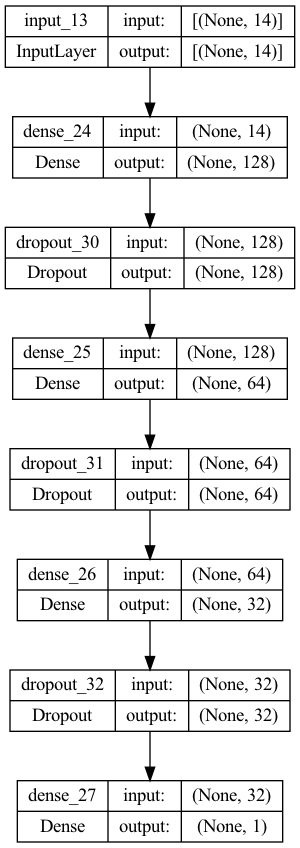

In [220]:
# buiding network
inputs = Input(shape=(X_train.shape[1],))
hiddens = Dense(128, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(64, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, outputs)
plot_model(model, show_shapes=True)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

2023-06-20 00:54:05.751408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 00:54:07.797433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  41%|████       41/100 ETA: 00:24s,   2.40epochs/s

Epoch 41: early stopping


Training:  41%|████       41/100 ETA: 00:29s,   2.03epochs/s


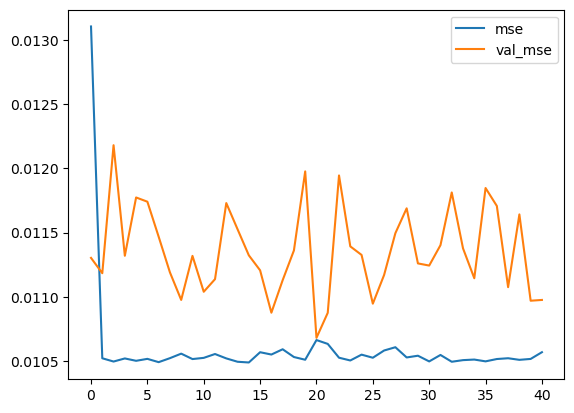

In [221]:
# fit model
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                    callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]), label='train')
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]), label='test')
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

 1/57 [..............................] - ETA: 12s

2023-06-20 00:54:25.742718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 28ms/step


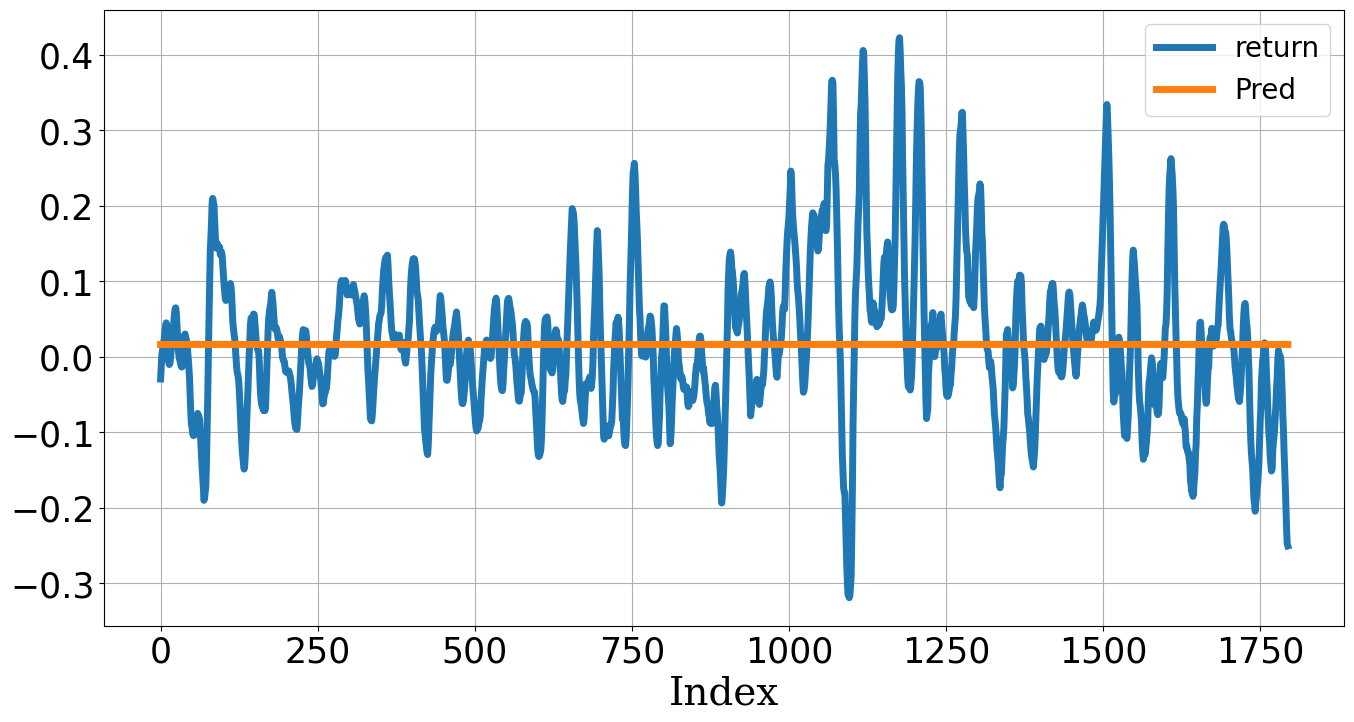

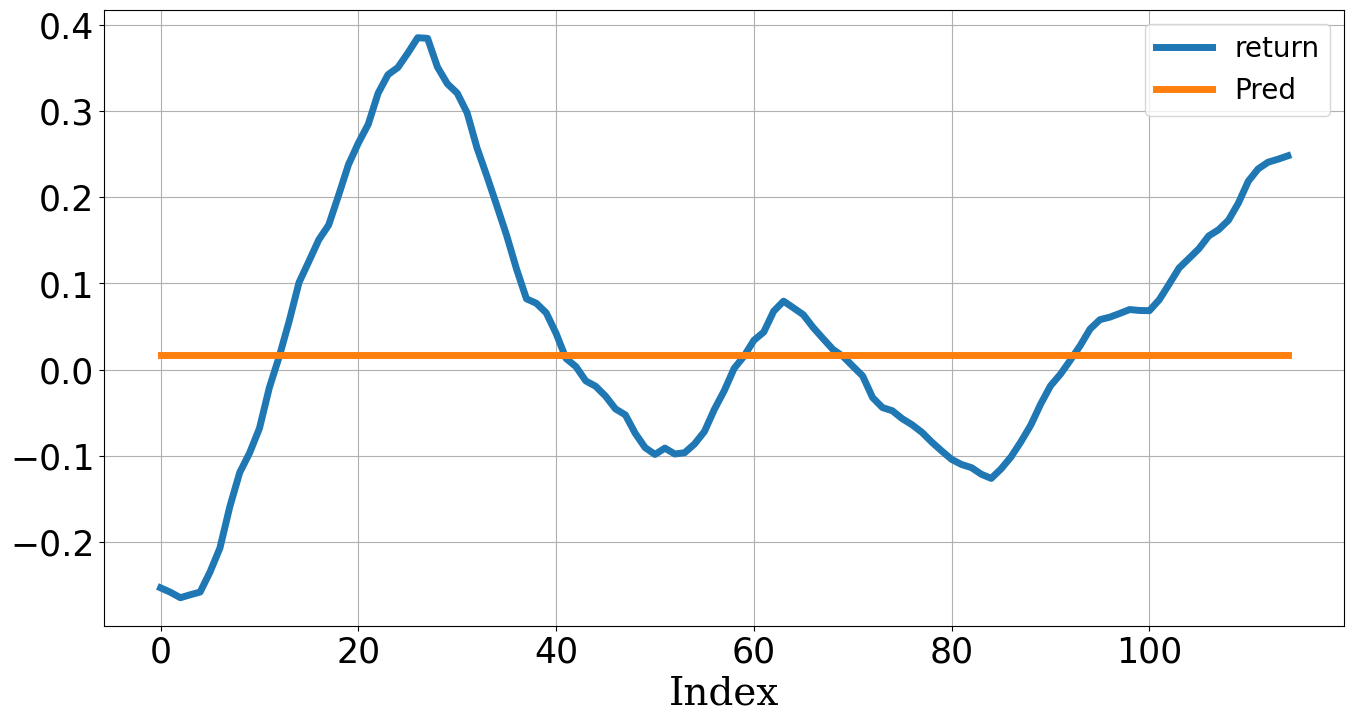

In [222]:
## Predict
Y_train_pred = pd.DataFrame(model.predict(X_train), index=Y_train.index, columns=['Pred'])
Y_test_pred = pd.DataFrame(model.predict(X_test), index=Y_test.index, columns=['Pred'])

plot_prediction(pd.concat([Y_train, Y_train_pred], axis=1).reset_index().iloc[:, 1:])
plot_prediction(pd.concat([Y_test, Y_test_pred], axis=1).reset_index().iloc[:, 1:])

In [223]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_train_pred, Y_test, Y_test_pred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,0.08,0.01,20.91
Test,0.12,0.02,1.17


20/57 [=========>....................] - ETA: 0s

2023-06-20 00:54:27.354534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step


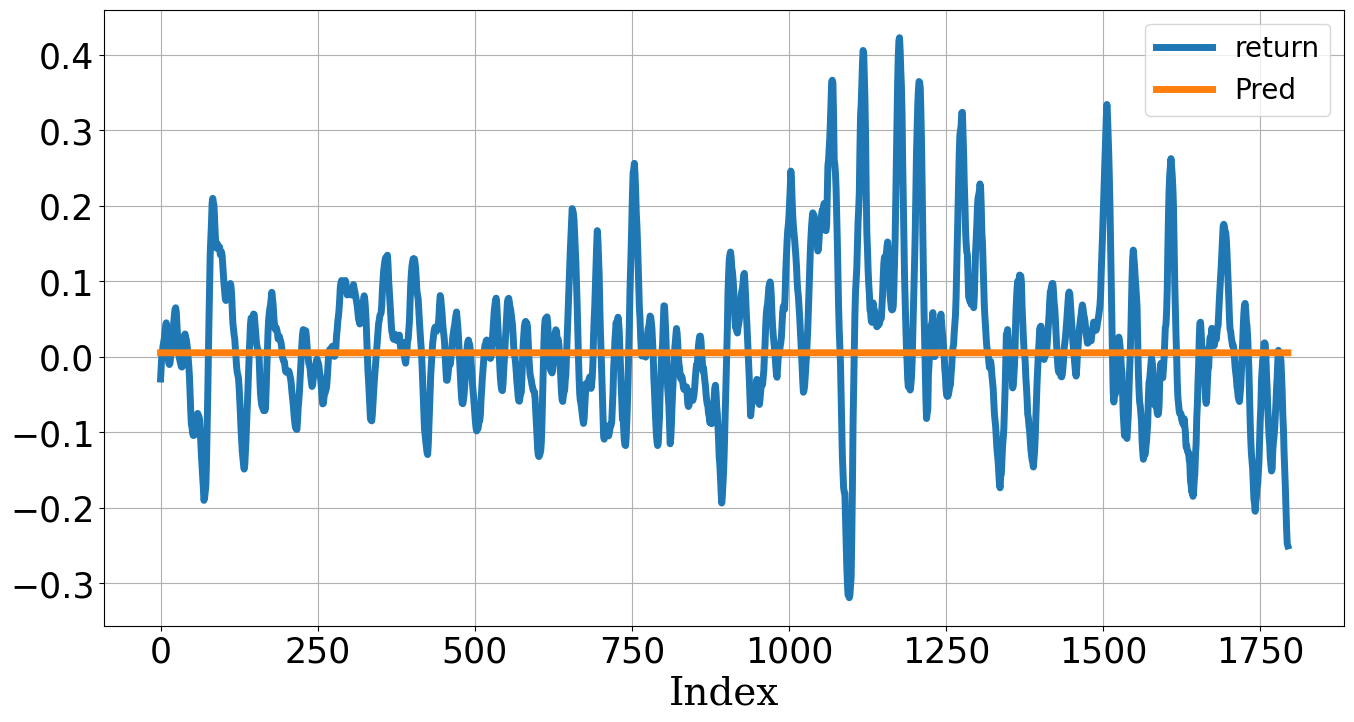

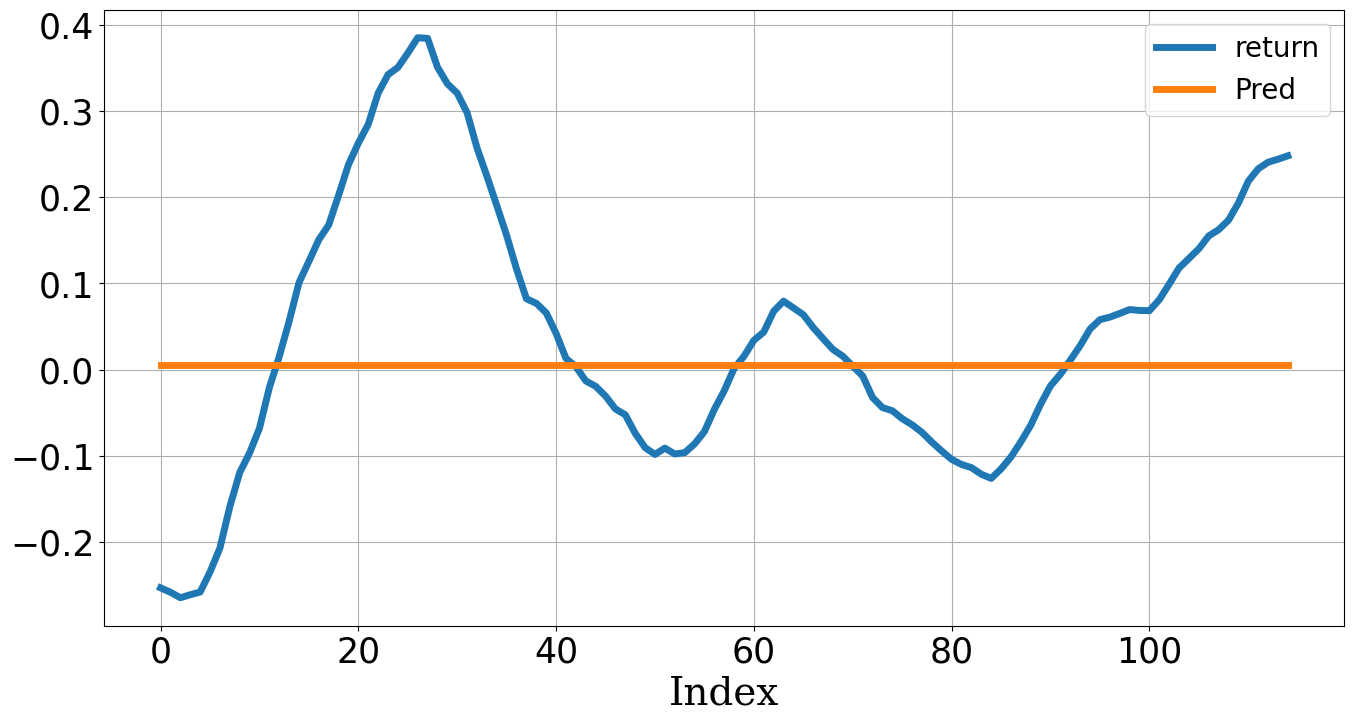

,MAE,MSE,MAPE
Train,0.08,0.01,7.47
Test,0.12,0.03,1.01


In [224]:
# load best model
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# CNN

In [225]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
################
EARLYSTOP_PATIENT = 20
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','tesla_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################


In [226]:
# reshape
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1795, 14, 1) Y_train: (1795, 1)
X_test: (115, 14, 1) Y_test: (115, 1)


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 14, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 14, 128)           512       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 dropout_33 (Dropout)        (None, 7, 128)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 64)             24640     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3, 64)            0         
 1D)                                                      

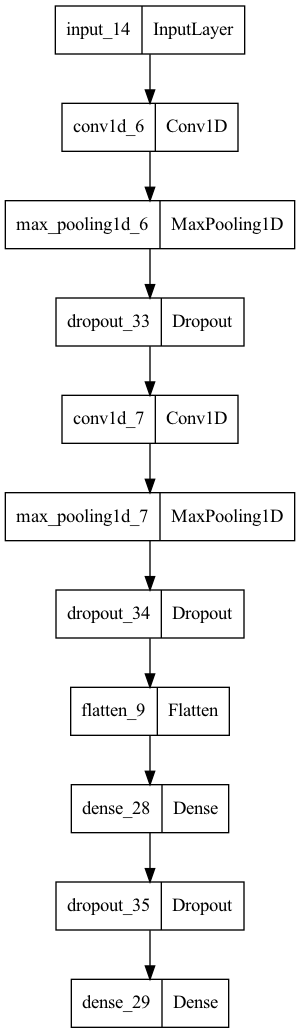

In [227]:
# build network
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))   
hiddens = Conv1D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv1D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-20 00:54:29.459709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 00:54:31.189762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  24%|██▍        24/100 ETA: 00:28s,   2.66epochs/s

Epoch 24: early stopping


Training:  24%|██▍        24/100 ETA: 00:37s,   2.01epochs/s


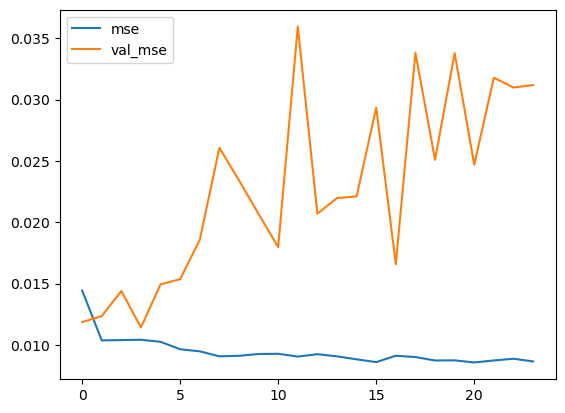

In [228]:
## 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-20 00:54:41.506254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step


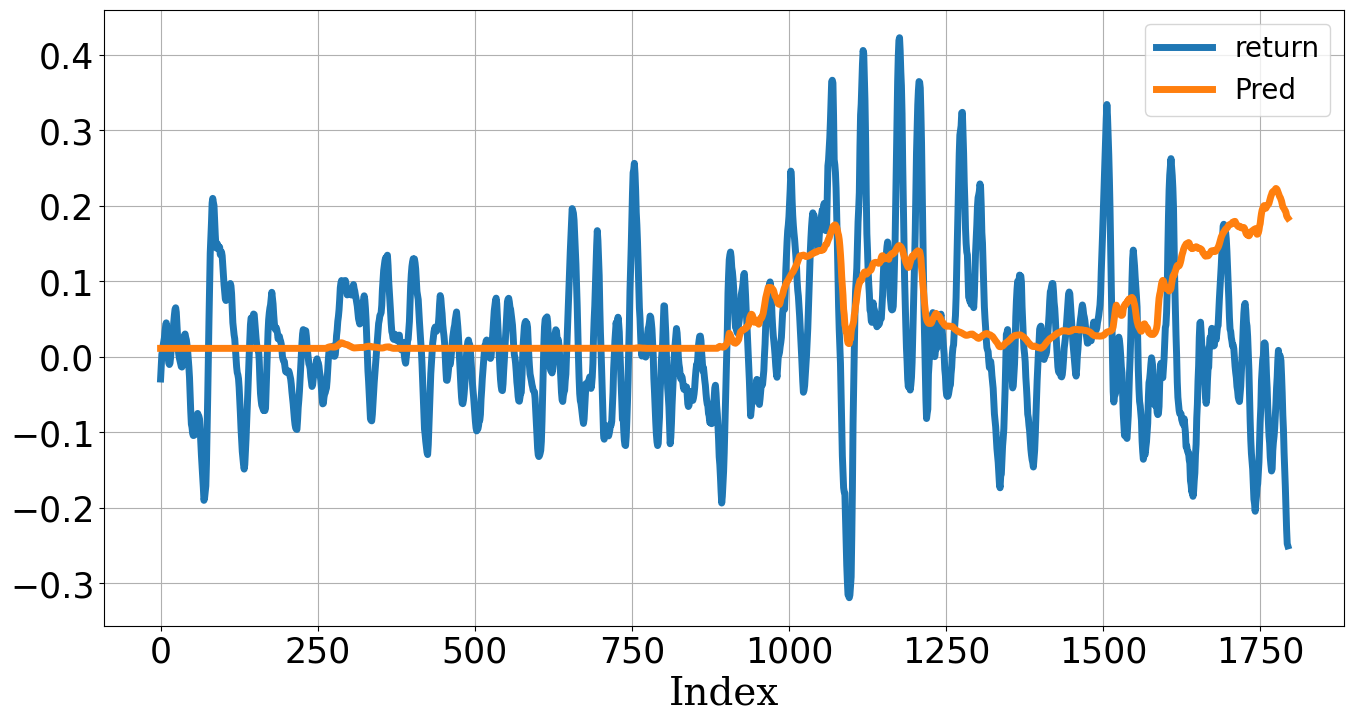

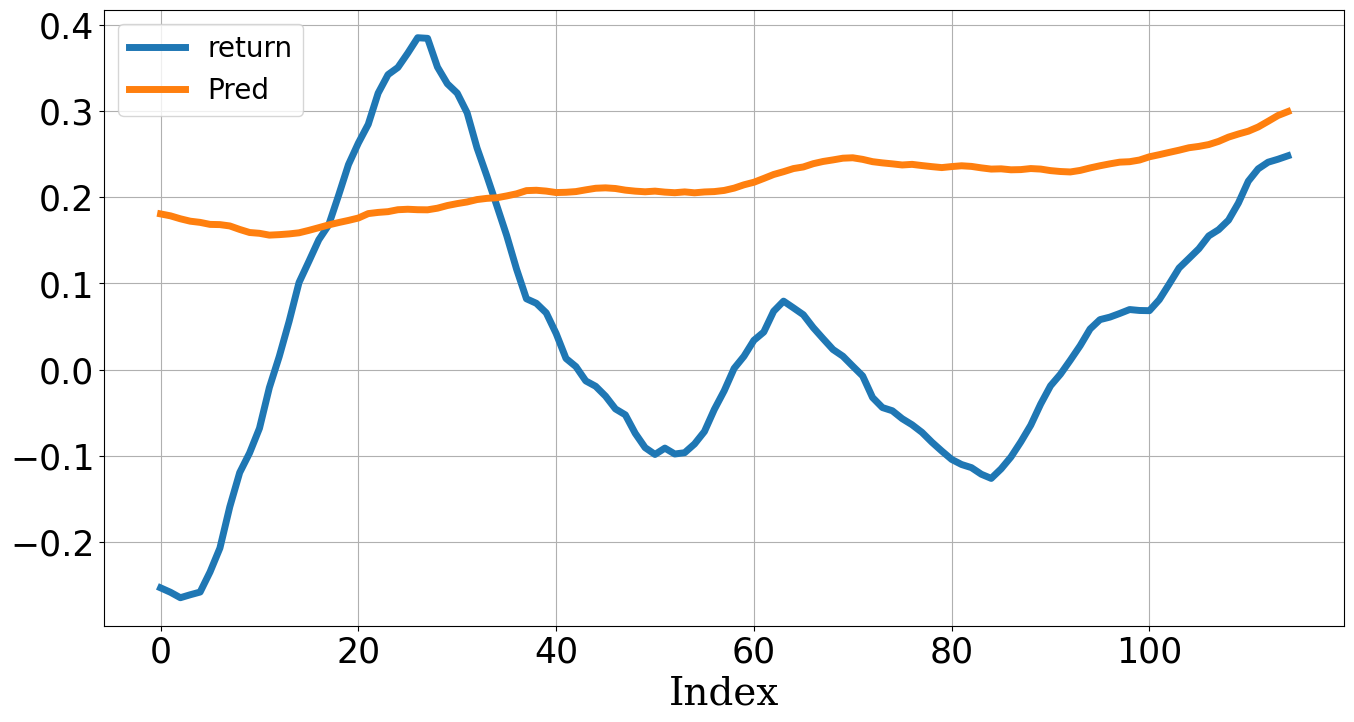

,MAE,MSE,MAPE
Train,0.08,0.01,18.14
Test,0.21,0.05,6.39


In [229]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

 5/57 [=>............................] - ETA: 0s

2023-06-20 00:54:43.520615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 25ms/step


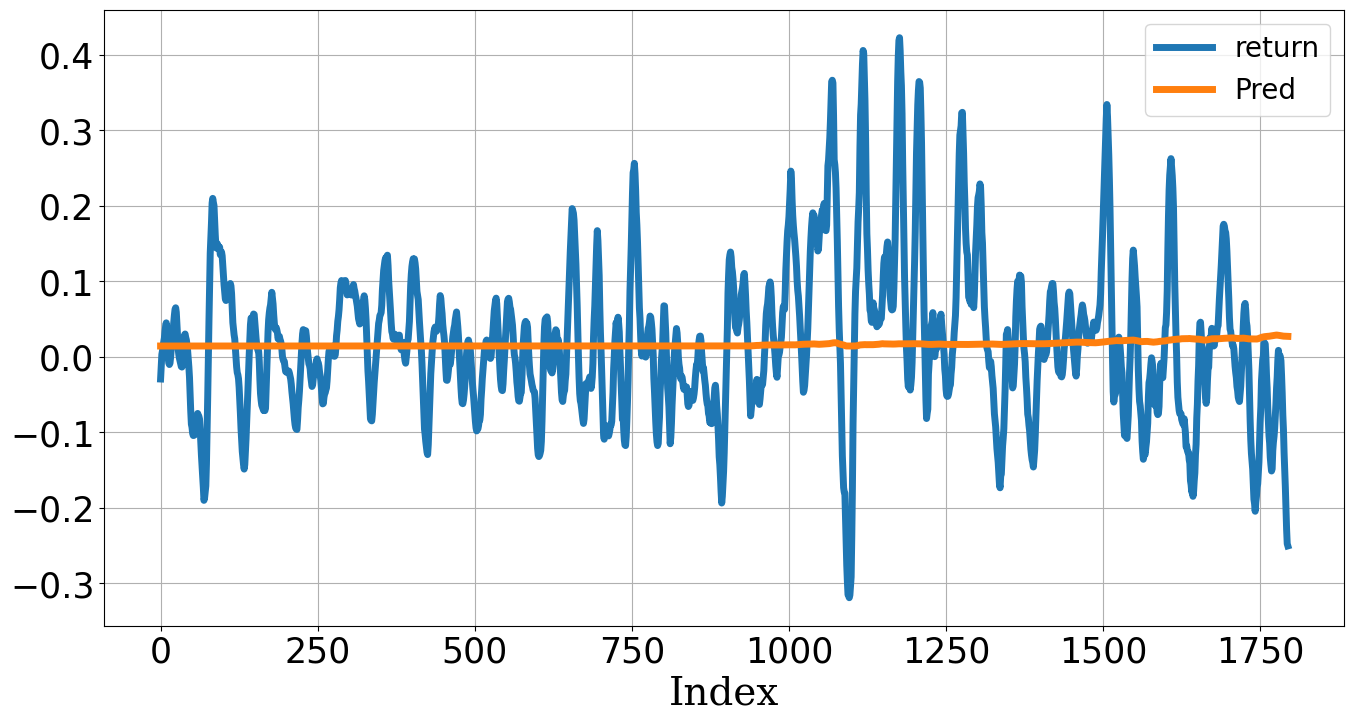

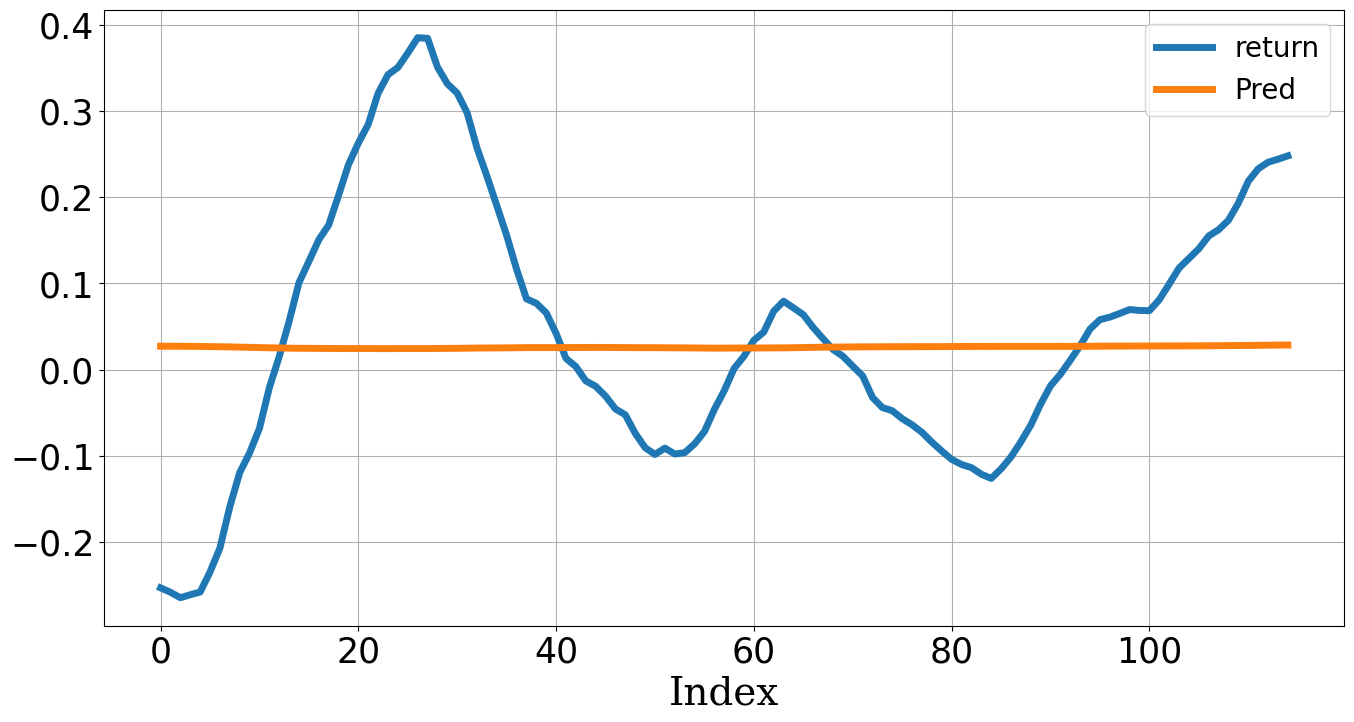

,MAE,MSE,MAPE
Train,0.08,0.01,18.62
Test,0.12,0.02,1.34


In [230]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# RNN

In [231]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'tesla_RNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

In [232]:
# # sequence 데이터 추출 및 변환
# seq_length = 12
# X_reshape, Y_resahpe = [], []
# for index in range(len(X_train) - seq_length + 1):
#     X_reshape.append(np.array(X_train[index: index + seq_length]))      # sequence 길이의 row 선택 후 붙이기
#     Y_resahpe.append(np.ravel(Y_train[index + seq_length - 1: index + seq_length]))  # sequence 길이를 제외하고 1개씩 붙이기

# # arrange
# X_reshape, Y_resahpe = np.array(X_reshape), np.array(Y_resahpe)
# Y_resahpe = pd.DataFrame(Y_resahpe, index=Y_train.index[seq_length-1:], columns=Y_train.columns)
# print('origin X: ', X_train.shape, '-> reshape X: ', X_reshape.shape)
# print('origin Y: ', Y_train.shape, '-> reshape Y: ', Y_resahpe.shape)

In [233]:
# reshape 함수화
def reshape_2Dto3Dseq(df_X, df_Y, seq_length):
    # generate sequence
    X_reshape, Y_resahpe = [], []
    for index in range(len(df_X) - seq_length + 1):
        X_reshape.append(np.array(df_X[index: index + seq_length]))      # sequence 길이의 row 선택 후 붙이기
        Y_resahpe.append(np.ravel(df_Y[index + seq_length - 1: index + seq_length]))    # sequence 길이를 제외하고 1개씩 붙이기
    
    # arrange
    X_reshape, Y_resahpe = np.array(X_reshape), np.array(Y_resahpe)
    Y_resahpe = pd.DataFrame(Y_resahpe, index=df_Y.index[seq_length-1:], columns=df_Y.columns)

    print('origin X: ', df_X.shape, '-> reshape X: ', X_reshape.shape)
    print('origin Y: ', df_Y.shape, '-> reshape Y: ', Y_resahpe.shape)

    return X_reshape, Y_resahpe

SEQUENCE = 12
X, Y = reshape_2Dto3Dseq(X_train, Y_train, SEQUENCE)

origin X:  (1795, 14, 1) -> reshape X:  (1784, 12, 14, 1)
origin Y:  (1795, 1) -> reshape Y:  (1784, 1)


In [234]:
# train & test 형태 변경
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_test), axis=0),     # numpy series 합치기 -> np.concatenate
                         pd.concat([Y_train, Y_test], axis=0), SEQUENCE) # pandas series 합치기 -> pd.concat
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length], Y.iloc[:-test_length]
X_test, Y_test = X[-test_length:], Y.iloc[-test_length:]
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

origin X:  (1910, 14, 1) -> reshape X:  (1899, 12, 14, 1)
origin Y:  (1910, 1) -> reshape Y:  (1899, 1)
X_train:  (1784, 12, 14, 1) Y_train:  (1784, 1)
X_test:  (115, 12, 14, 1) Y_test:  (115, 1)


In [235]:
# 데이터 백업
X_trprep3D, X_teprep3D = X_train.copy(), X_test.copy()
Y_trprep3D, Y_teprep3D = Y_train.copy(), Y_test.copy()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12, 14)]          0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 12, 128)           18304     
                                                                 
 dropout_36 (Dropout)        (None, 12, 128)           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 12, 64)            12352     
                                                                 
 dropout_37 (Dropout)        (None, 12, 64)            0         
                                                                 
 flatten_10 (Flatten)        (None, 768)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 769

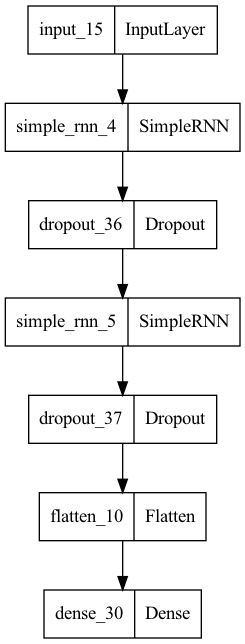

In [236]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = SimpleRNN(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
                    activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = SimpleRNN(64, return_sequences=True,
                    activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-20 00:54:46.951497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 00:54:54.656142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  11%|█          11/100 ETA: 09:42s,   6.55s/epochs

Epoch 11: early stopping


Training:  11%|█          11/100 ETA: 10:12s,   6.89s/epochs


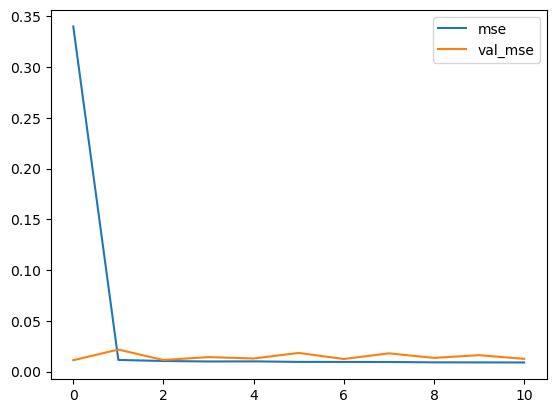

In [237]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-20 00:56:02.590121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 53ms/step


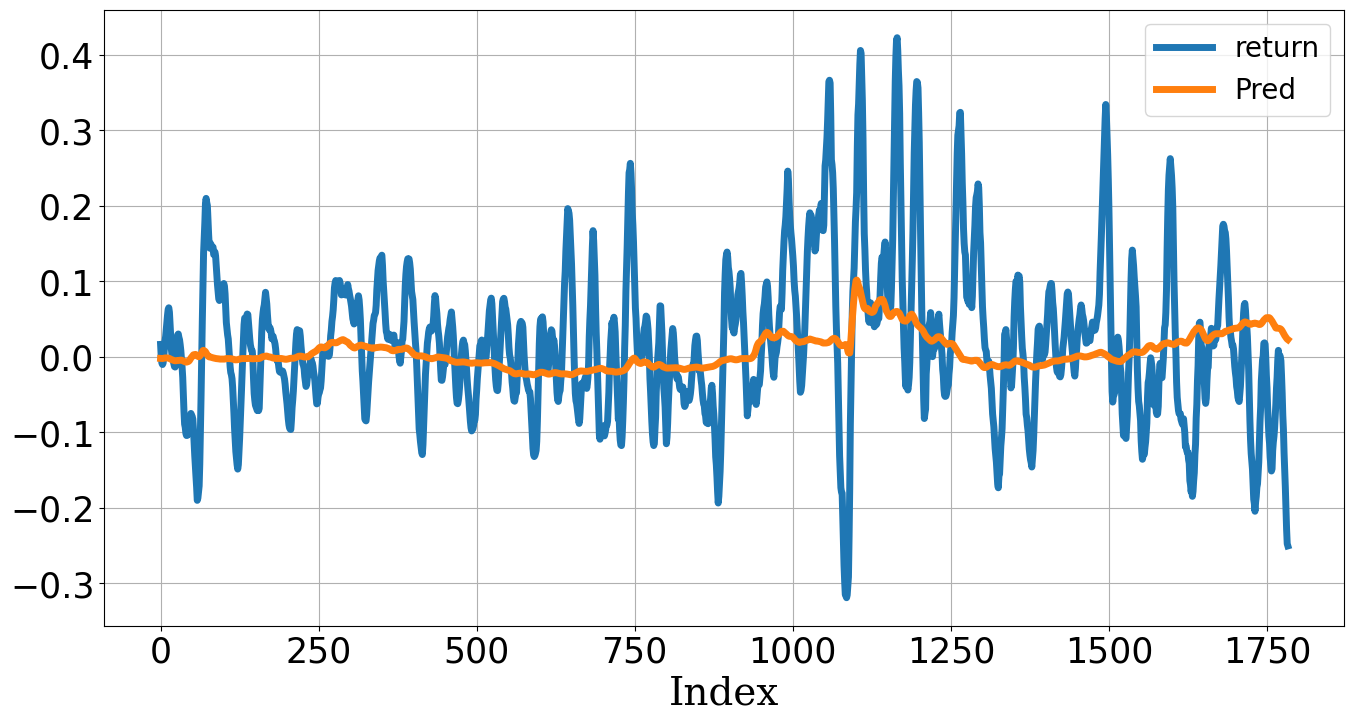

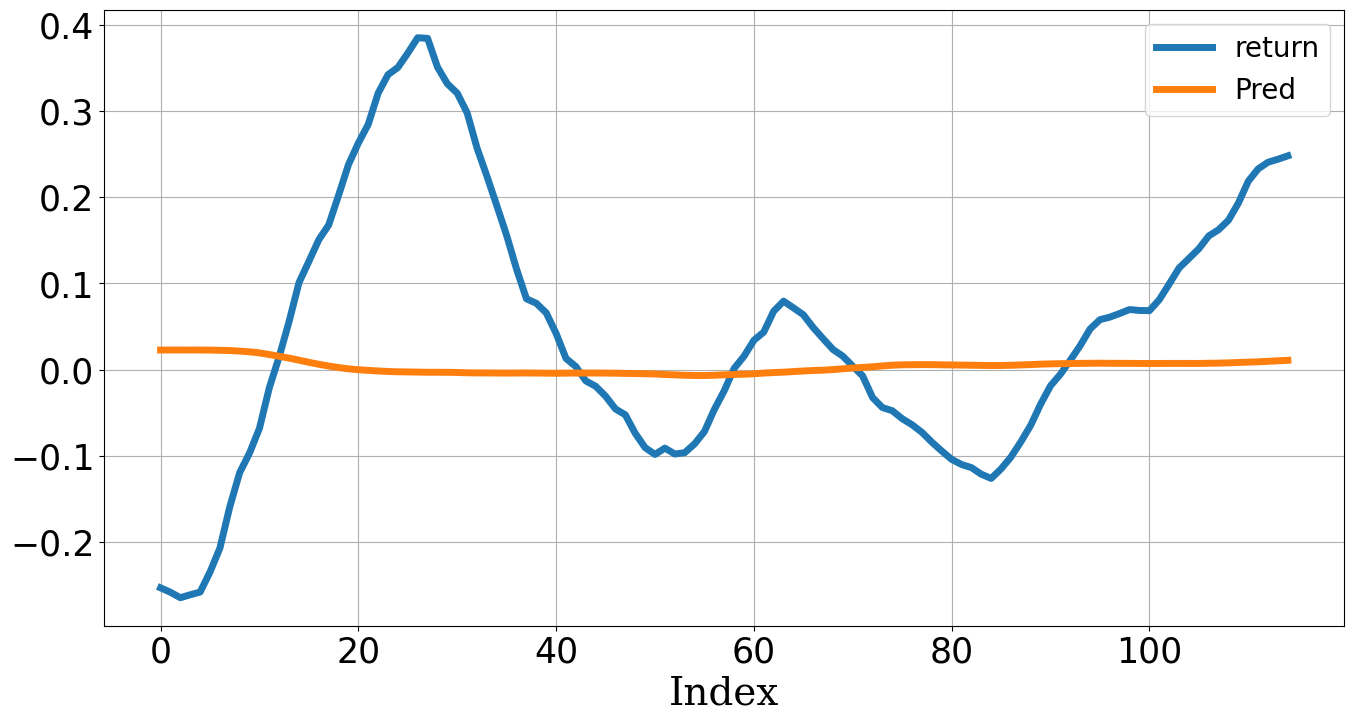

In [238]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [239]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,0.07,0.01,4.52
Test,0.13,0.03,1.06


 1/56 [..............................] - ETA: 15s

2023-06-20 00:56:06.764050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 72ms/step


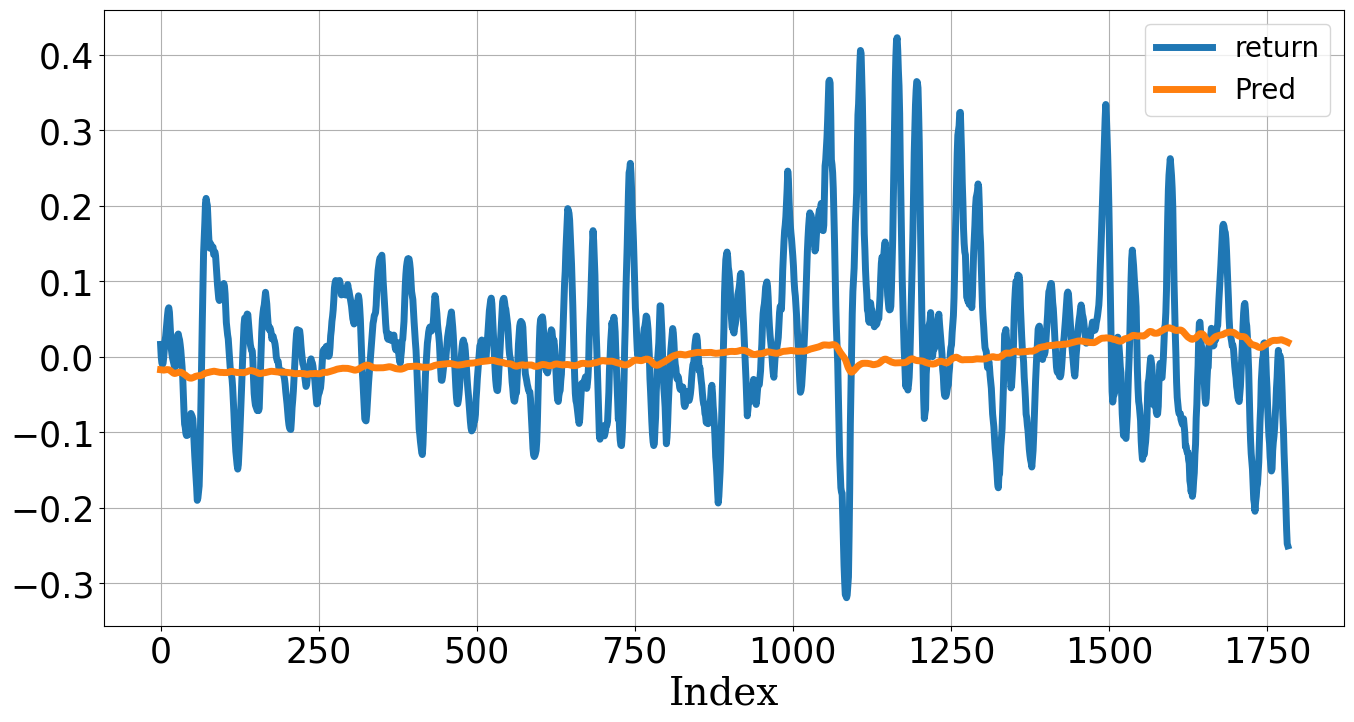

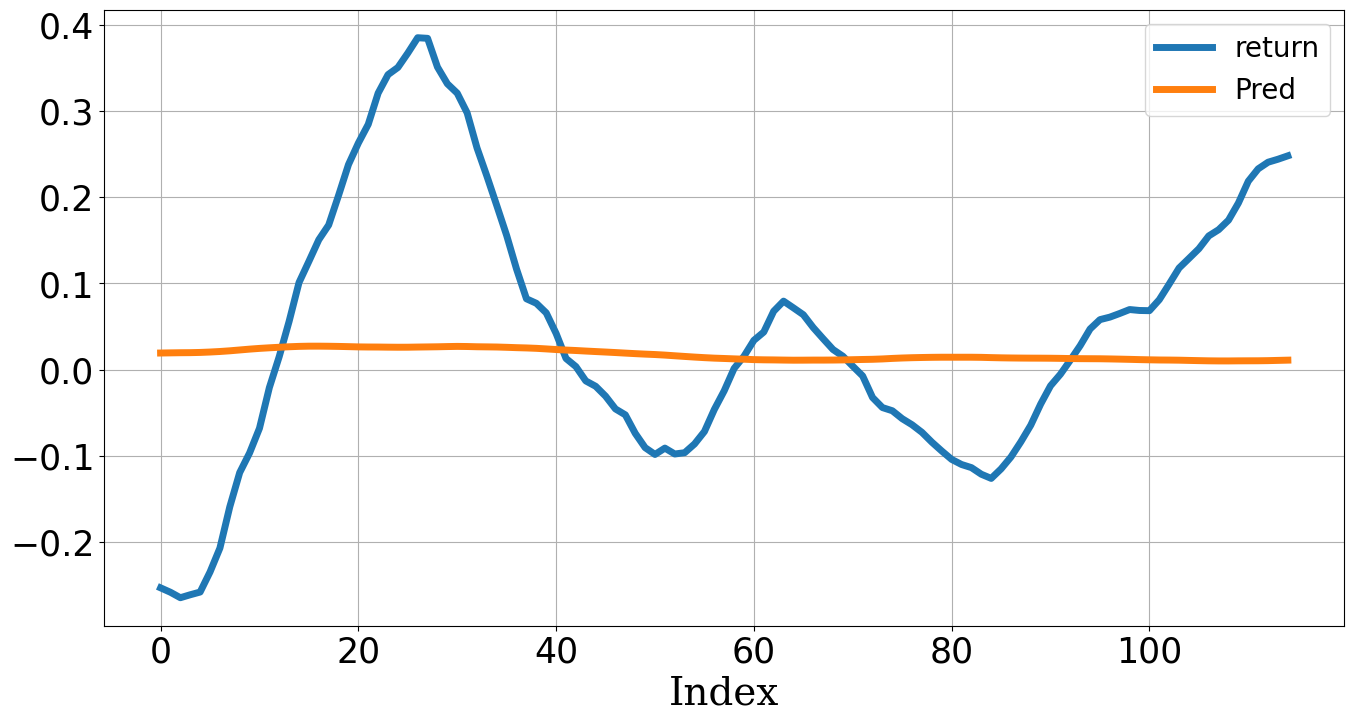

,MAE,MSE,MAPE
Train,0.08,0.01,21.92
Test,0.12,0.02,1.15


In [240]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)


# LSTM

In [241]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'tesla_LSTM.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 12, 14)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 128)           73216     
                                                                 
 dropout_38 (Dropout)        (None, 12, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_39 (Dropout)        (None, 12, 64)            0         
                                                                 
 flatten_11 (Flatten)        (None, 768)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 769

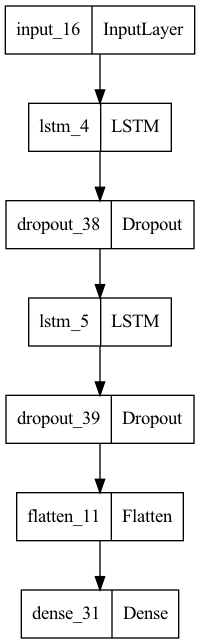

In [242]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = LSTM(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
               activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = LSTM(64, return_sequences=True,
               activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-20 00:56:12.903866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 00:56:28.831592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  11%|█          11/100 ETA: 20:30s,  13.82s/epochs

Epoch 11: early stopping


Training:  11%|█          11/100 ETA: 20:58s,  14.14s/epochs


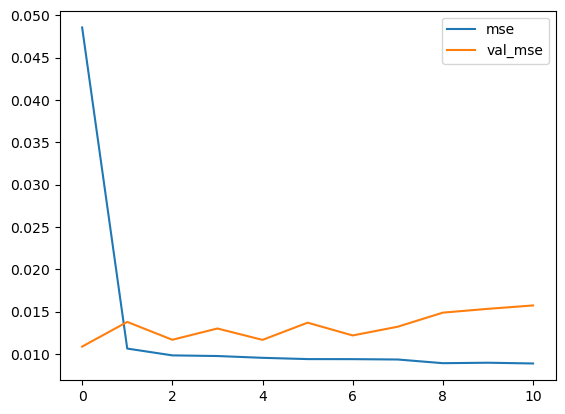

In [243]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-20 00:58:47.216114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 105ms/step


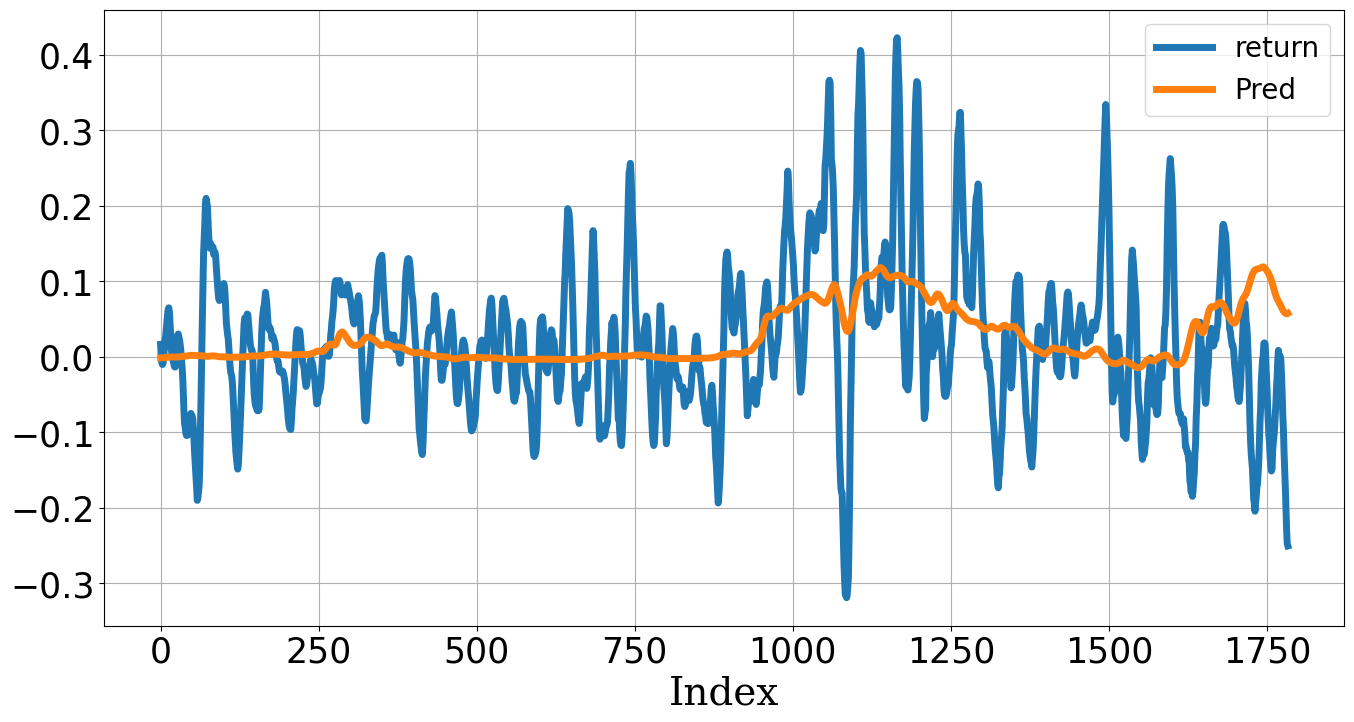

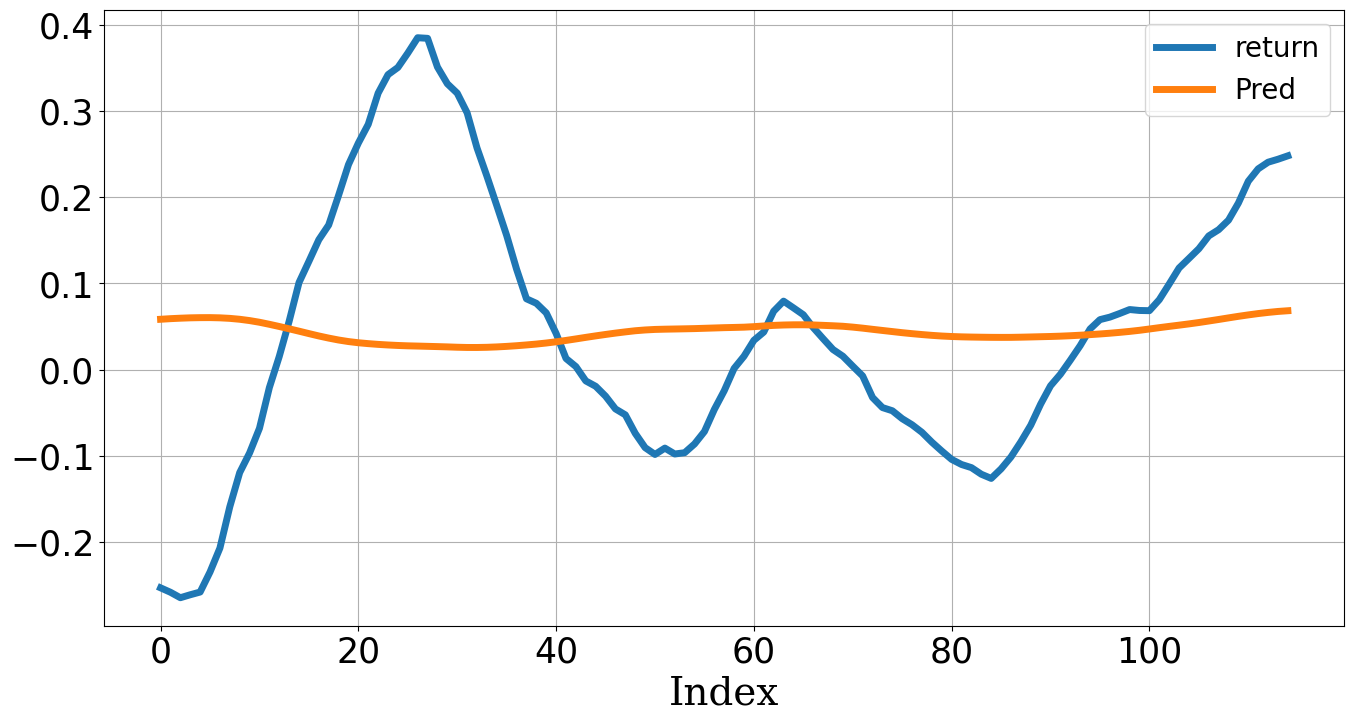

In [244]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [245]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,0.07,0.01,4.62
Test,0.13,0.03,1.74


2023-06-20 00:58:52.751035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 108ms/step


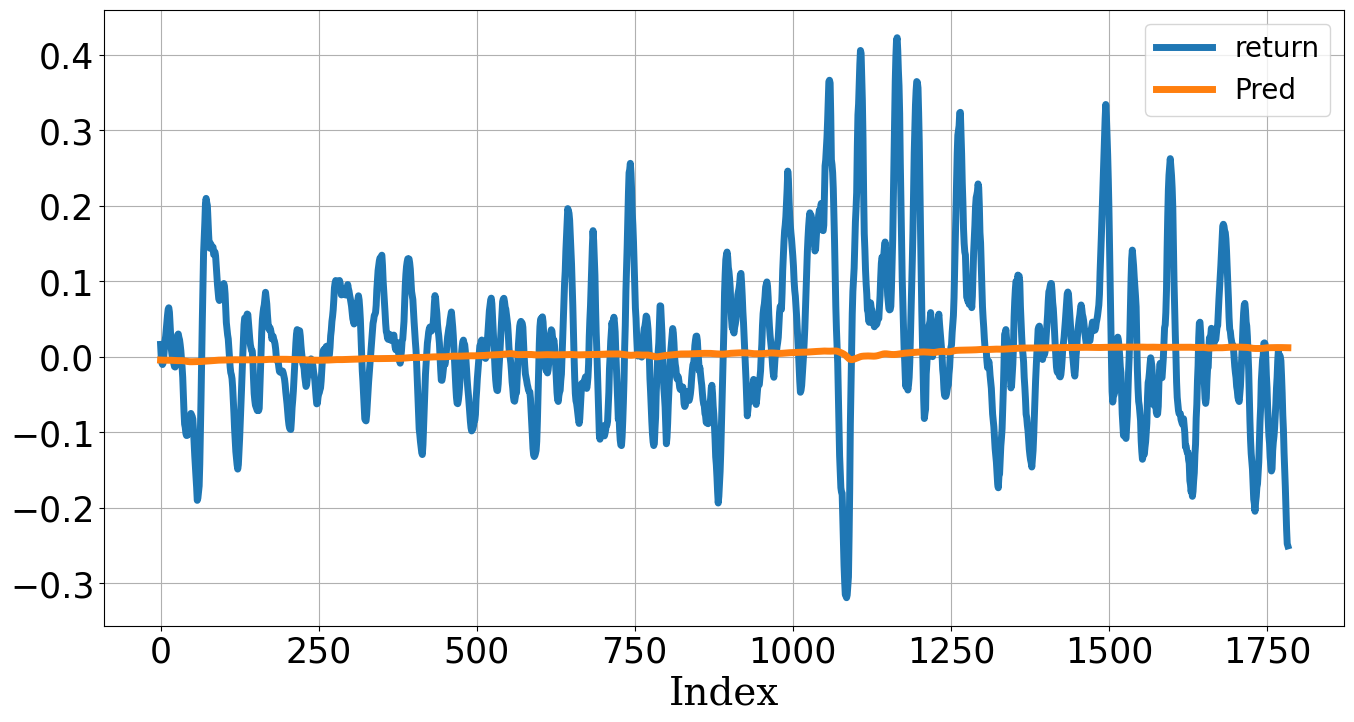

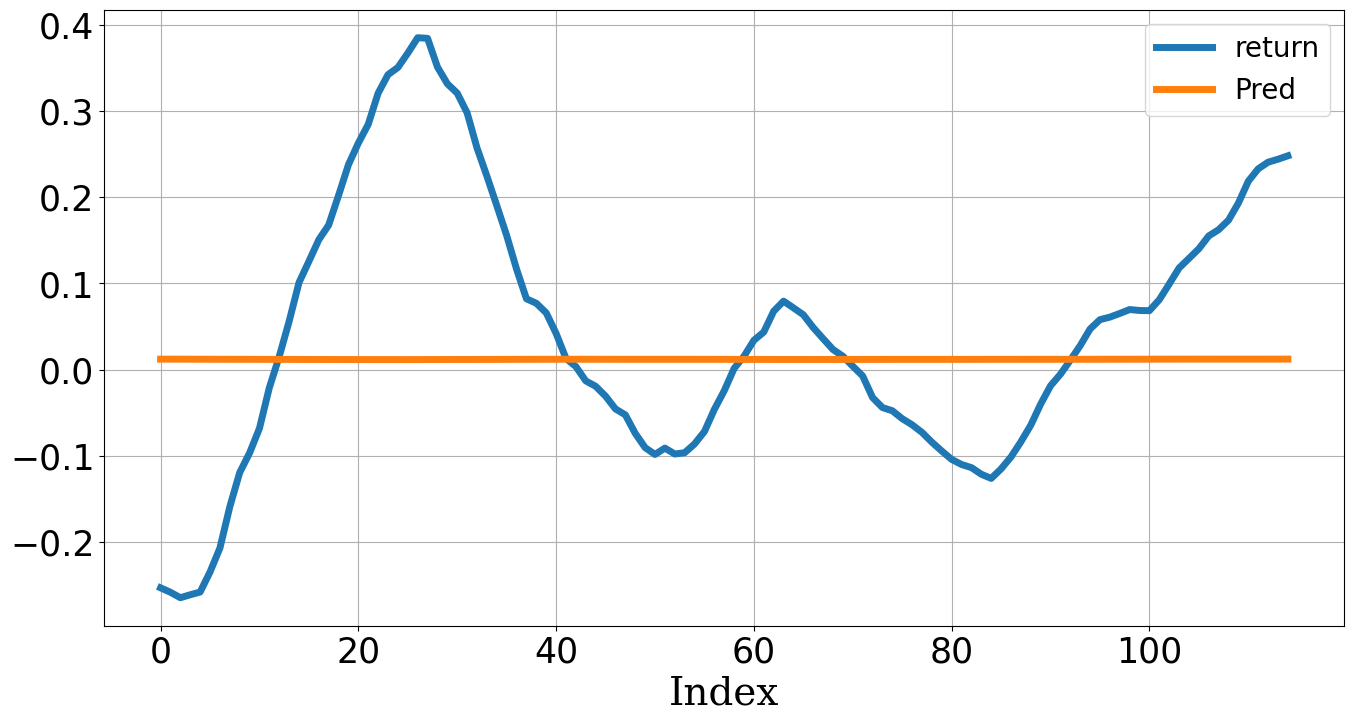

,MAE,MSE,MAPE
Train,0.08,0.01,6.26
Test,0.12,0.02,1.10


In [246]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# GRU

In [247]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BARCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'tesla_GRU.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 12, 14)]          0         
                                                                 
 gru_4 (GRU)                 (None, 12, 128)           55296     
                                                                 
 dropout_40 (Dropout)        (None, 12, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 12, 64)            37248     
                                                                 
 dropout_41 (Dropout)        (None, 12, 64)            0         
                                                                 
 flatten_12 (Flatten)        (None, 768)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 769

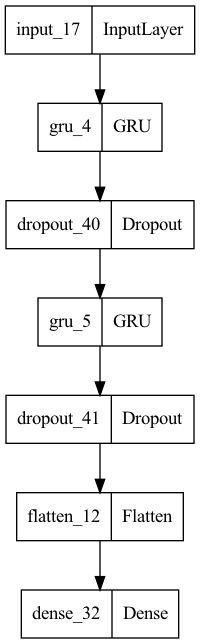

In [248]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = GRU(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
               activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = GRU(64, return_sequences=True,
               activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-20 00:59:00.715382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 00:59:19.681743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  11%|█          11/100 ETA: 26:07s,  17.61s/epochs

Epoch 11: early stopping


Training:  11%|█          11/100 ETA: 25:14s,  17.01s/epochs


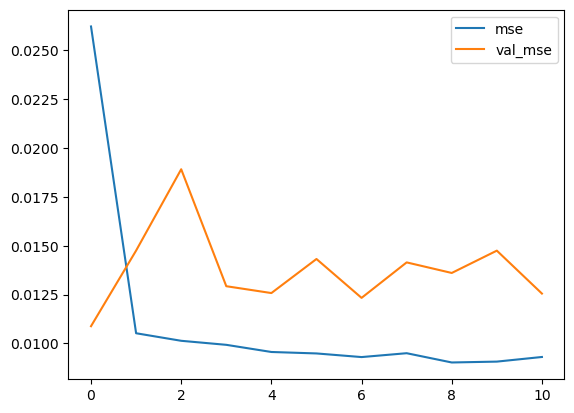

In [249]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BARCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-20 01:02:07.162489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 151ms/step


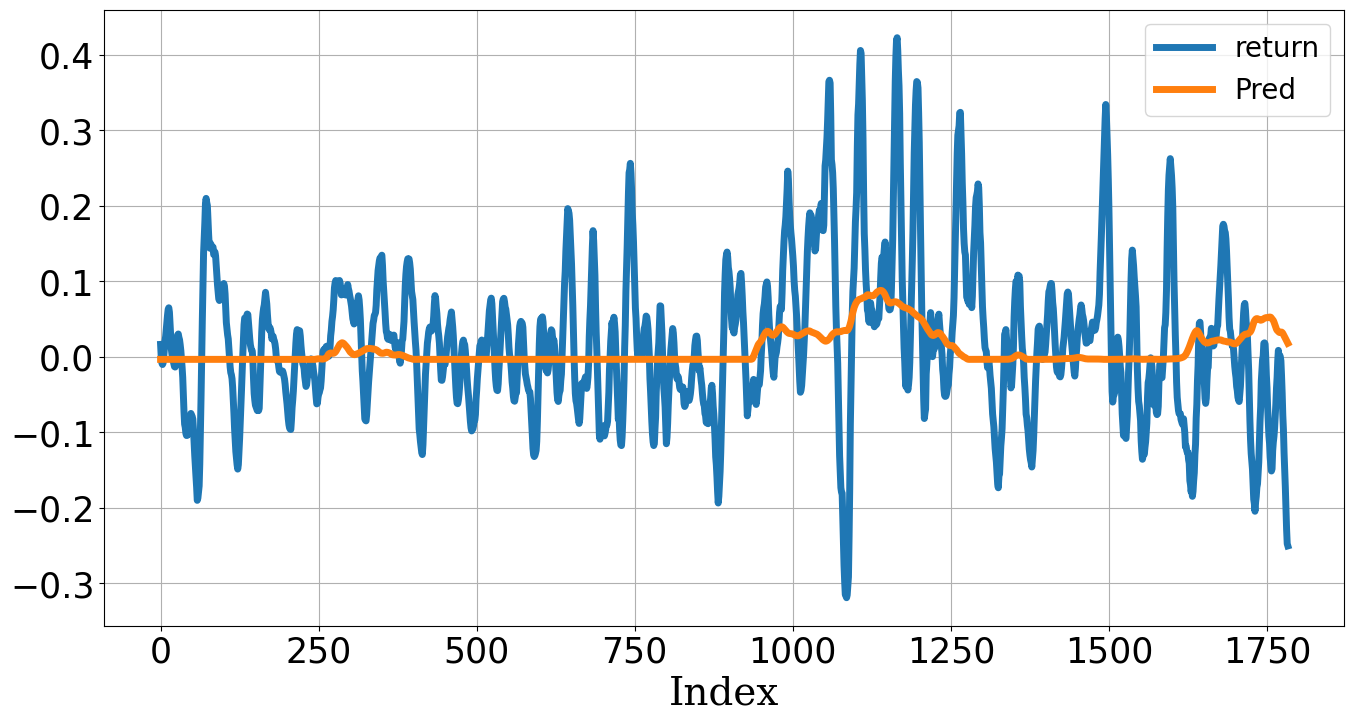

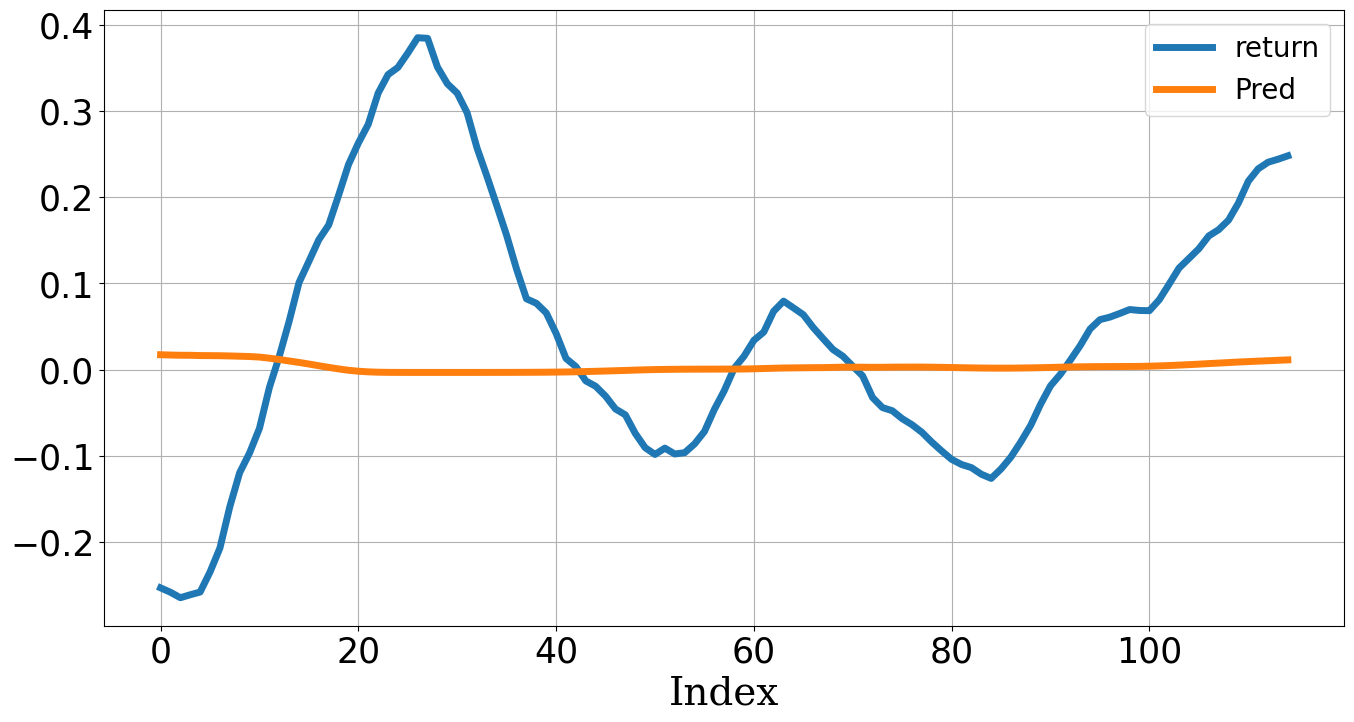

In [250]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [251]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,0.07,0.01,5.68
Test,0.13,0.03,1.00


2023-06-20 01:02:15.341823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 381ms/step


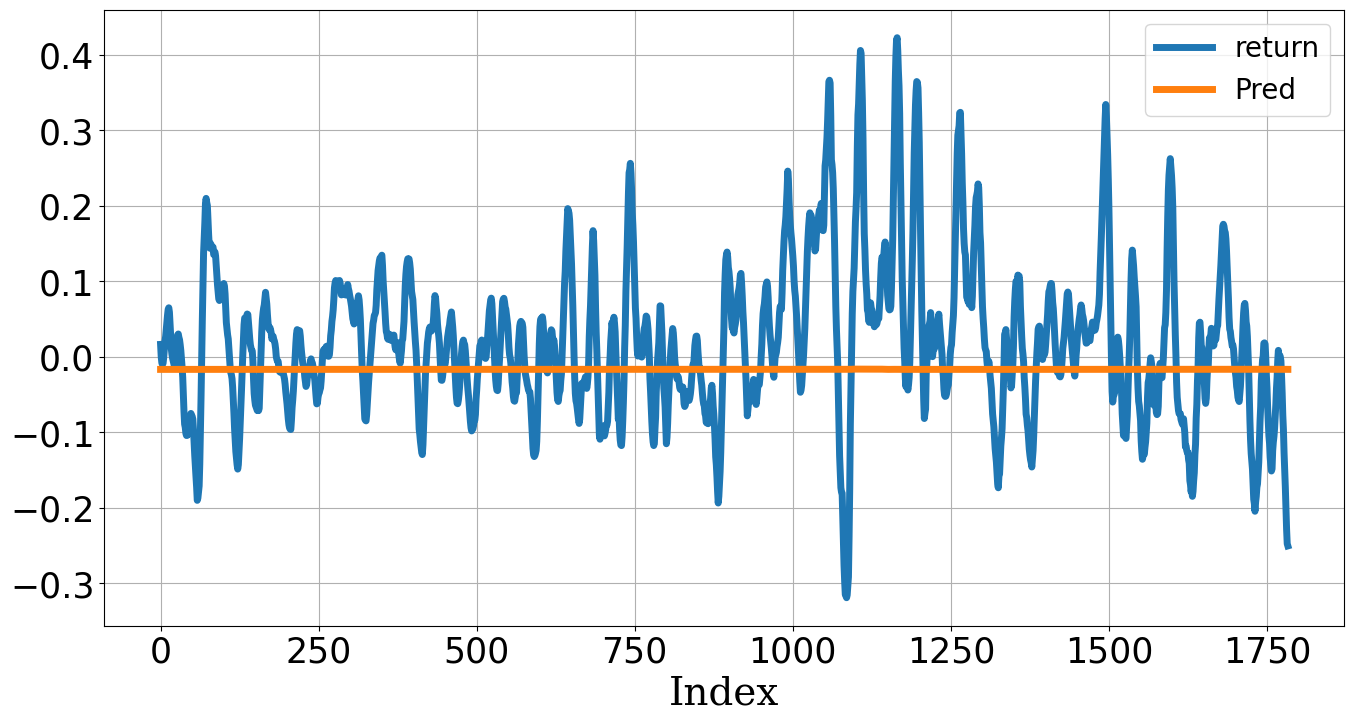

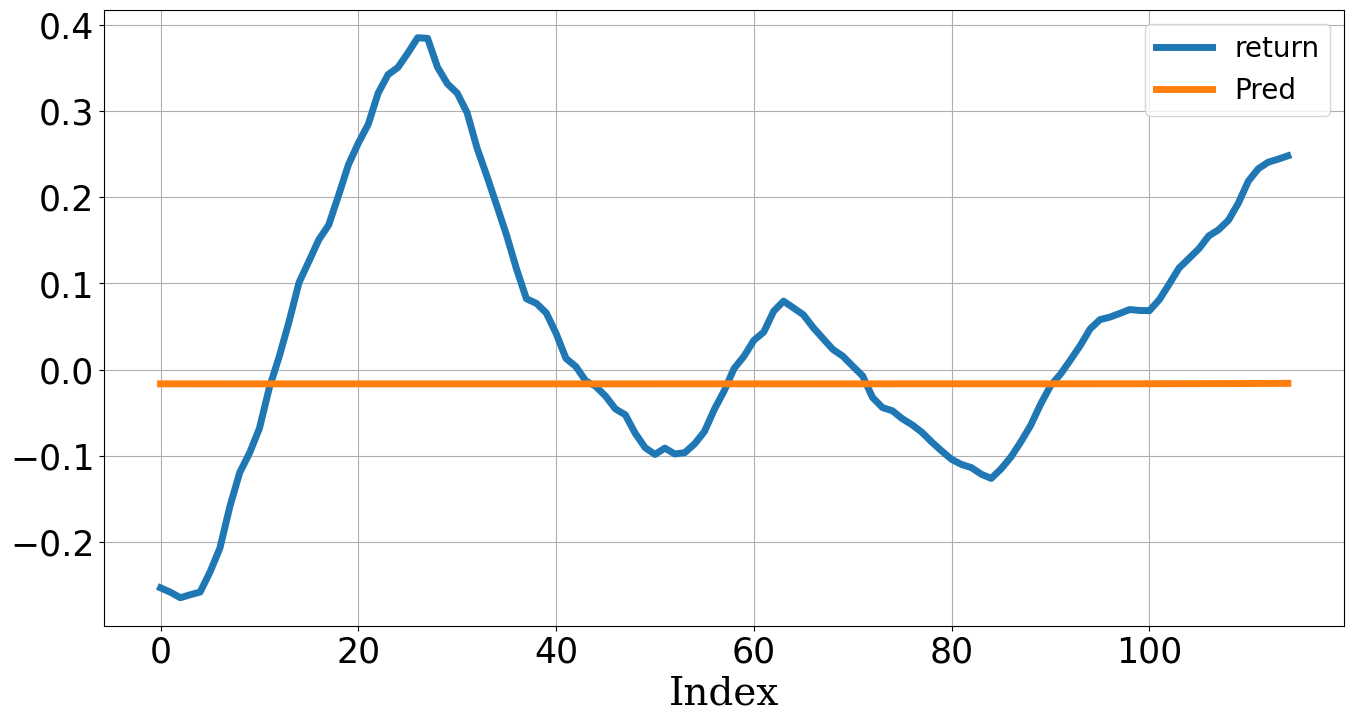

,MAE,MSE,MAPE
Train,0.08,0.01,21.35
Test,0.13,0.03,1.23


In [252]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# LSTM + Transformer

# Result Summary

MLP


2023-06-20 01:02:26.158251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 87ms/step
CNN


2023-06-20 01:02:27.818043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 39ms/step


2023-06-20 01:02:29.844408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 111ms/step


2023-06-20 01:02:31.571180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 134ms/step


2023-06-20 01:02:32.878966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 176ms/step


,MAE,MSE,MAPE
MLP,0.12,0.03,1.01
CNN,0.12,0.02,1.34
RNN,0.12,0.02,1.15
LSTM,0.12,0.02,1.10
GRU,0.13,0.03,1.23


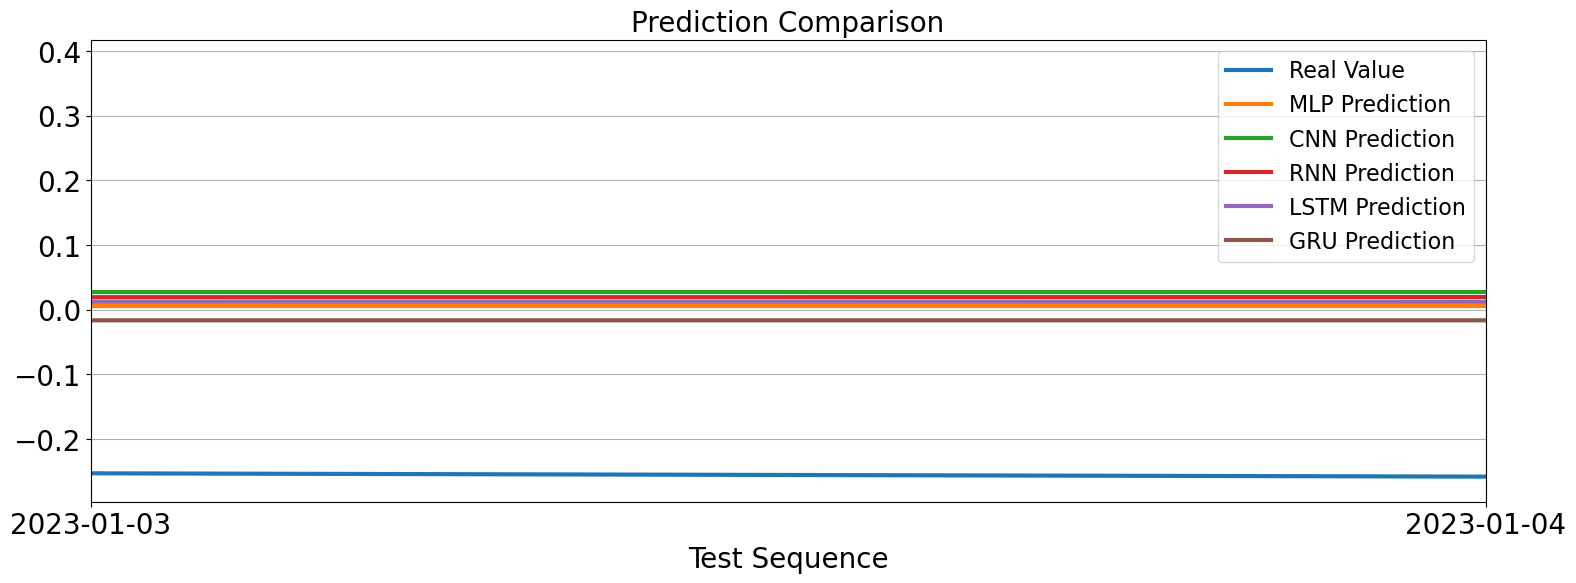

In [253]:
# 저장 모델 불러오기
modelnames = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU']

# 결과 정리
Y_pred, Score_final = Y_test.copy(), pd.DataFrame()
for each in modelnames:
    FILENAME = os.path.join(os.getcwd(), 'Model', 'tesla_'+each+'.h5')
    
    # 베스트 모델 로딩
    model = load_model(FILENAME)
    
    ## 예측하기
    if each in ['MLP', 'CNN']:
        print(each)
        Y_tepred = pd.DataFrame(model.predict(X_teprep2D), 
                                index=Y_teprep2D.index, columns=['Pred'])
        
        # 분석 검증
        Score_nn_early = evaluation_reg(Y_teprep2D, Y_tepred)
        
        # 결과 붙이기
        Y_pred = pd.concat([Y_pred, Y_tepred], axis=1)
        Score_final = pd.concat([Score_final, Score_nn_early.iloc[[0],:]], axis=0)
    else:
        Y_tepred = pd.DataFrame(model.predict(X_teprep3D), 
                                index=Y_teprep3D.index, columns=['Pred'])
        
        # 분석 검증
        Score_nn_early = evaluation_reg(Y_teprep3D, Y_tepred)
        
        # 결과 붙이기
        Y_pred = pd.concat([Y_pred, Y_tepred], axis=1)
        Score_final = pd.concat([Score_final, Score_nn_early.iloc[[0],:]], axis=0)
  
# 정리
Y_pred.columns = ['Real Value']+[i+' Prediction' for i in modelnames]
Score_final.index = modelnames
    
# 결과 출력
display(Score_final)
Y_pred.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
            xlim=(Y_pred.index.min(),Y_pred.index.max()))
plt.title('Prediction Comparison', fontsize=20)
plt.xlabel('Test Sequence', fontsize=20)
plt.ylabel('', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.show()